In [2]:
#!/usr/bin/env python

import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt

# Read points from text file
def readPoints(path) :
    # Create an array of points.
    points = [];
    # Read points
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(x), int(y)))

    return points

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Warps and alpha blends triangular regions from img1 and img2 to img
def morphTriangle(img1, img2, img, t1, t2, t, alpha) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))


    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []


    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask


In [4]:
#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri

In [6]:
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

In [14]:
filename1 = 'donald_trump.jpg'
filename2 = 'ted_cruz.jpg'
alpha = 0

# Read images
img1 = cv2.imread(filename1);
img2 = cv2.imread(filename2);

# Convert Mat to float data type
img1 = np.float32(img1)
img2 = np.float32(img2)

# Read array of corresponding points
points1 = readPoints(filename1 + '.txt')
points2 = readPoints(filename2 + '.txt')
points = [];

# Compute weighted average point coordinates
for i in range(0, len(points1)):
    x = ( 1 - alpha ) * points1[i][0] + alpha * points2[i][0]
    y = ( 1 - alpha ) * points1[i][1] + alpha * points2[i][1]
    points.append((x,y))


# Allocate space for final output
imgMorph = np.zeros(img1.shape, dtype = img1.dtype)

# Find convex hull
hull1 = []
hull2 = []
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])
hullIndex = np.array([x for x in range(68)])
for i in range(0, len(hullIndex)):
    hull1.append(points1[int(hullIndex[i])])
    hull2.append(points2[int(hullIndex[i])])

dt = calculateDelaunayTriangles(rect, hull2)


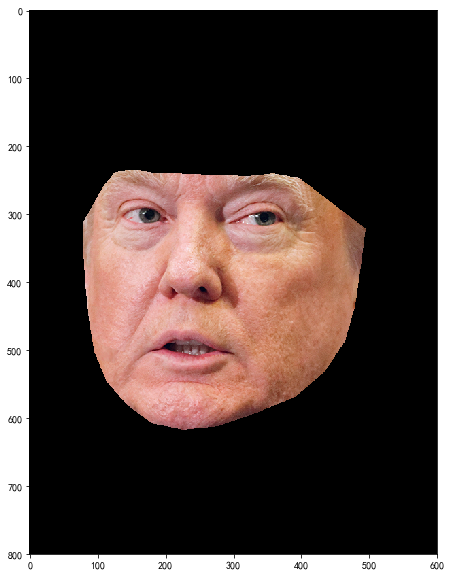

In [15]:
for tup in dt :
    x = int(tup[0])
    y = int(tup[1])
    z = int(tup[2])

    t1 = [points1[x], points1[y], points1[z]]
    t2 = [points2[x], points2[y], points2[z]]
    t = [ points[x], points[y], points[z] ]

    # Morph one triangle at a time.
    morphTriangle(img1, img2, imgMorph, t1, t2, t, alpha)


# Display Result
plt.figure(figsize=(12, 10))
plt.imshow((imgMorph[:,:,::-1]).astype(np.uint8))
